In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import numpy as np
import xgboost as xgb
from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
from sklearn import preprocessing, decomposition
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import confusion_matrix
import itertools
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, sent_tokenize
import re
from bs4 import BeautifulSoup
%matplotlib inline
from yellowbrick.text import FreqDistVisualizer

In [2]:
#df=pd.read_csv('./stackOverFlowDataWithGroup.csv',index_col=False,na_values='',na_filter=True,usecols=['text','label'])
df=pd.read_csv('./stackOverFlowData-5-labels.csv',sep=';')
df = df[pd.notnull(df['label'])]
#df = df.sample(frac=0.9, random_state=99).reset_index(drop=True)
print(df.head(40000))

                                                    text          label
0      How can I configure DNS for my local Cloud Ser...          cloud
1                  No permission to open MySQL audit log  data-analysis
2                  Dictionary data structure in React JS       frontend
3         applying CSS for particular td tag in a column       frontend
4                  styling bootstrap-vue dropdown button       frontend
...                                                  ...            ...
39995  calculating employee bonus through nested if s...        backend
39996            Looking to get data from multiple sites        backend
39997  Python 3.8+ Does Not Recognize File In Same Fo...        backend
39998                         How to link lists in order        backend
39999  Python subproccess.Popen() error: Fatal error ...        backend

[40000 rows x 2 columns]


## Explore the data 

In [3]:
data_words_sum = df['text'].apply(lambda x: len(x.split(' '))).sum()
print("We have " + str(data_words_sum) + " words in the data")

We have 446304 words in the data


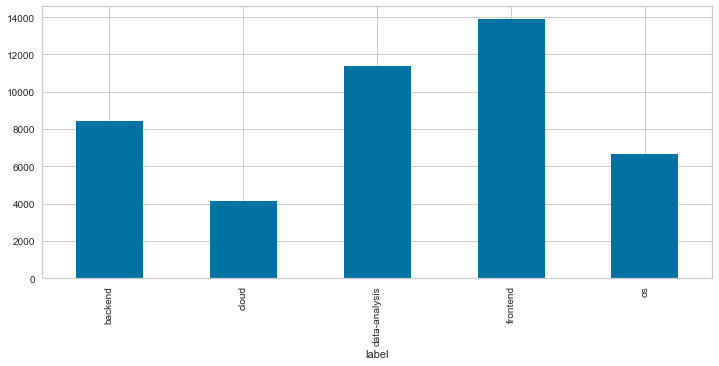

In [4]:
fig = plt.figure(figsize=(12,5))
df.groupby('label').text.count().plot.bar(ylim=0)
plt.show();

## Check the Data
After loading the data, it’s good practice to run some checks on it: pick a few samples and manually check if they are consistent with our expectations. For example, print a few random samples to see if the label corresponds to the content of the post.

In [5]:
def print_plot(index):
    example = df[df.index == index][['text', 'label']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Label:', example[1])
print_plot(300)
print_plot(30005)
print_plot(3002)

Two views named RNCPicker / Yarn: how to share dependency between dependencies?
Label: frontend
MYSQL get data group by date [duplicate]
Label: data-analysis
Have to render a react component based on props that changes a js variable
Label: frontend


## Visualize Token (vocabulary) Frequency Distribution Before Text Preprocessing
A frequency distribution tells us the frequency of each vocabulary item in the text.

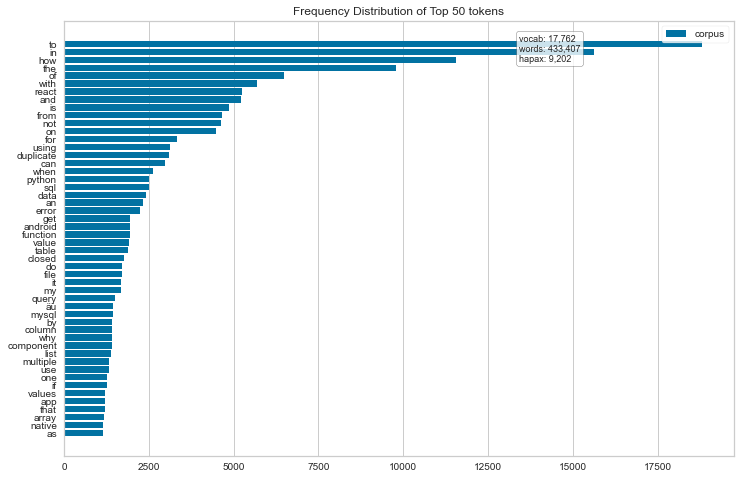

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [6]:
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(df['text'])
features   = vectorizer.get_feature_names()
plt.figure(figsize=(12,8))
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
for label in visualizer.ax.texts:
    label.set_size(20)
visualizer.poof()

## Clean up the data
For this particular data set, our text cleaning includes the following steps:

* HTML decoding. The BeautifulSoup's text attribute will return a string stripped of any HTML tags and metadata.
* Remove stop words,
* Change text to lower case
* Remove punctuation
* Remove bad characters and so on.

In [7]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

In [8]:
df['text'] = df['text'].apply(clean_text)

In [9]:
print_plot(300)
print_plot(30005)

two views named rncpicker yarn share dependency dependencies
Label: frontend
mysql get data group date duplicate
Label: data-analysis


In [10]:
data_words_sum = df['text'].apply(lambda x: len(x.split(' '))).sum()
print("After cleaning up the data, we have " + str(data_words_sum) + " words in the data")

After cleaning up the data, we have 287474 words in the data


## Visualize Token Frequency Distribution After Text Preprocessing

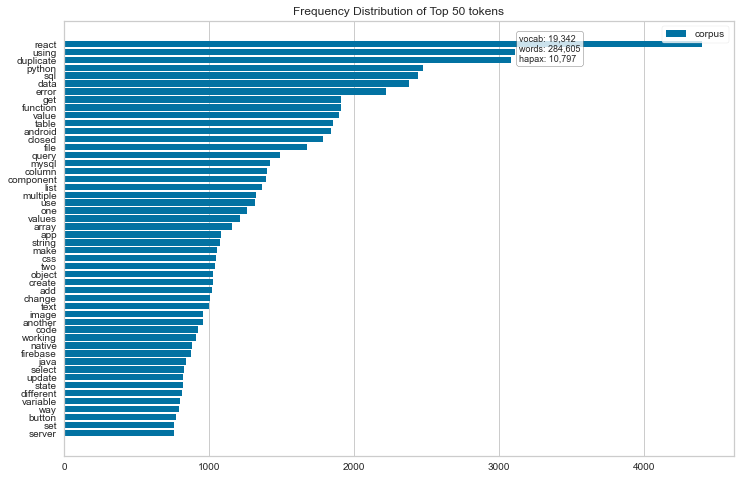

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [11]:
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(df['text'])
features   = vectorizer.get_feature_names()
plt.figure(figsize=(12,8))
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
for label in visualizer.ax.texts:
    label.set_size(20)
visualizer.poof()

### Visually Compare the Differences in the Frequency Distributions for Two of the Tags: “backend” and “data-analysis”.
It tells us the differences in tokens across different labels. 

#### Tokens distribution of label "backend"

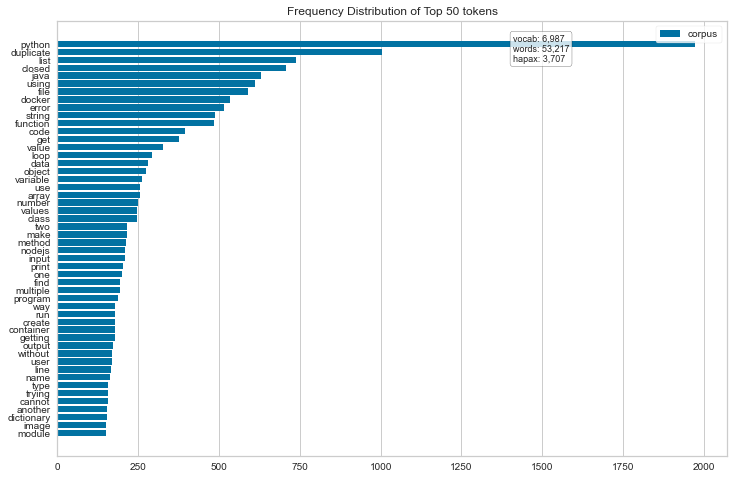

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [12]:
docs       = vectorizer.fit_transform(text for text in df.loc[df['label'] == 'backend']['text'])
features   = vectorizer.get_feature_names()
plt.figure(figsize=(12,8))
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
visualizer.poof()

#### Tokens distribution of label "data-analysis"¶

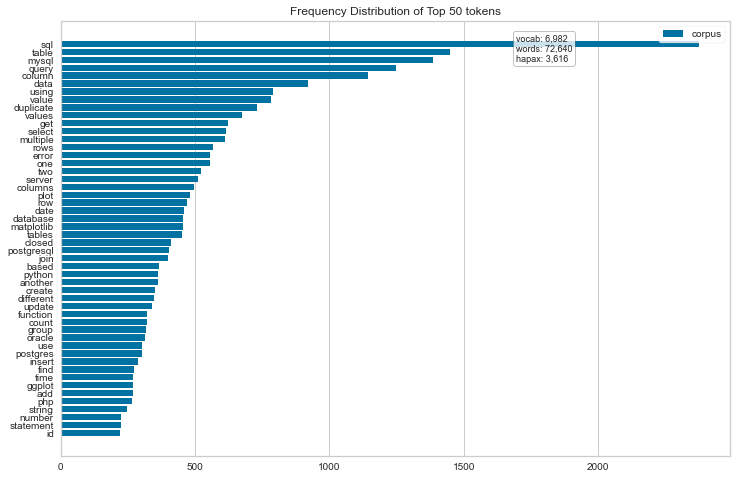

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [13]:
docs       = vectorizer.fit_transform(text for text in df.loc[df['label'] == 'data-analysis']['text'])
features   = vectorizer.get_feature_names()
plt.figure(figsize=(12,8))
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
visualizer.poof()

## Training data
We will conver our text to a matrix of token counts, then tansform a count matrix to a normalized tf-idf representation (tf-idf transform)

A core step for a typical NLP component is to convert raw text into features, which give a machine learning model a simpler, more focused view of the text.

* We use the LabelEncoder from scikit-learn to convert text labels to integers, 0, 1, 2, 3, ... 19.

* stratify=y will make sure that after random split, the classes are still balanced, in our case.

In [14]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(df.label.values)
X_train, X_test, y_train, y_test = train_test_split(df.text.values, y,
                                                   stratify=y, 
                                                   random_state=42, test_size=0.1)

### Tf-idf
term frequency-inverse document frequency

TF: Term Frequency, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length

IDF: Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance.

### TfidfVectorizer() 
Convert a collection of raw text or document to a matrix of Tf-idf features. And we will set important parameters.

* strip_accents='unicode', replace all accented unicode char by their corresponding ASCII char.
* analyzer='word', feature made of words.
* token_pattern=r'\w{1,}', tokenize only words of 1+ chars.
* ngram_range=(1, 3), features made of unigram, bigram, and trigram.
* use_idf=True, Enable inverse-document-frequency reweighting.
* smooth_idf=True, prevents zero division for unseen words.
* sublinear_tf=True, Regularization technique that squishes the data to a lower, common magnitude -> 1 + log(tf).
* stop_words='english', Cleans the text for common, low-impact, filter words such as the, a, an, in ..etc, to make way * for words that distinguish.

In [15]:
tfidf = TfidfVectorizer(strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=True,smooth_idf=True,sublinear_tf=True,
            stop_words = 'english')
# Fit and transform Tf-idf to both training and test sets
tfidf.fit(list(X_train) + list(X_test))
X_train_tfidf =  tfidf.transform(X_train) 
X_test_tfidf = tfidf.transform(X_test)

## BOW
Count: Convert a collection of text documents to a matrix of token counts. Every sample text is represented as a vector indicating the count of a token in the text.

Counting the occurrences of tokens in each document.

When using Countvectorizer(), the tokens that occurs very frequently in every document are not penalized.

In [16]:
countvec = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english', binary=True)
# Fit and transform CountVectorizer to both training and test sets
countvec.fit(list(X_train) + list(X_test))
X_train_countvec =  countvec.transform(X_train) 
X_test_countvec = countvec.transform(X_test)

In [17]:
target_names = lbl_enc.classes_
print(target_names)

['backend' 'cloud' 'data-analysis' 'frontend' 'os']


## Fitting Logistic Regression on Tf-idf

In [18]:
logregclf = LogisticRegression()
logregclf.fit(X_train_tfidf, y_train)
y_pred = logregclf.predict(X_test_tfidf)
print("---Test Set Results---")
print("Accuracy with logreg: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=target_names))

---Test Set Results---
Accuracy with logreg: 0.8412306310352571
               precision    recall  f1-score   support

      backend       0.77      0.81      0.79       845
        cloud       0.92      0.69      0.79       413
data-analysis       0.86      0.90      0.88      1138
     frontend       0.84      0.93      0.88      1389
           os       0.87      0.68      0.76       668

     accuracy                           0.84      4453
    macro avg       0.85      0.80      0.82      4453
 weighted avg       0.84      0.84      0.84      4453



/Users/zhiyiniu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Fitting Naive Bayes on Tf-idf

In [19]:
NBclf = MultinomialNB()
NBclf.fit(X_train_tfidf, y_train)
y_pred = NBclf.predict(X_test_tfidf)
print("---Test Set Results---")
print("Accuracy with NB: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=target_names))

---Test Set Results---
Accuracy with NB: 0.7464630586121715
               precision    recall  f1-score   support

      backend       0.83      0.60      0.70       845
        cloud       0.97      0.31      0.47       413
data-analysis       0.79      0.92      0.85      1138
     frontend       0.65      0.97      0.78      1389
           os       0.94      0.42      0.58       668

     accuracy                           0.75      4453
    macro avg       0.84      0.65      0.68      4453
 weighted avg       0.79      0.75      0.72      4453



## Fitting SVC (Support Vector Classifier) on Tf-idf

In [20]:
svd = decomposition.TruncatedSVD(n_components=200)
svd.fit(X_train_tfidf)
X_train_svd = svd.transform(X_train_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

scale = preprocessing.StandardScaler()
scale.fit(X_train_svd)
X_train_svd_scale = scale.transform(X_train_svd)
X_test_svd_scale = scale.transform(X_test_svd)

SVMclf = SVC()
SVMclf.fit(X_train_svd_scale, y_train)
y_pred = SVMclf.predict(X_test_svd_scale)
print("---Test Set Results---")
print("Accuracy with SVM after SVD and standardize: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=target_names))

---Test Set Results---
Accuracy with SVM after SVD and standardize: 0.804176959353245
               precision    recall  f1-score   support

      backend       0.66      0.81      0.73       845
        cloud       0.89      0.66      0.75       413
data-analysis       0.88      0.85      0.86      1138
     frontend       0.87      0.87      0.87      1389
           os       0.73      0.67      0.70       668

     accuracy                           0.80      4453
    macro avg       0.80      0.77      0.78      4453
 weighted avg       0.81      0.80      0.80      4453



## Fitting Logistic Regression on BOW

In [21]:
logregclf = LogisticRegression()
logregclf.fit(X_train_countvec, y_train)
y_pred = logregclf.predict(X_test_countvec)
print("---Test Set Results---")
print("Accuracy with logreg: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=target_names))

---Test Set Results---
Accuracy with logreg: 0.8612171569728273
               precision    recall  f1-score   support

      backend       0.77      0.84      0.81       845
        cloud       0.90      0.75      0.82       413
data-analysis       0.90      0.91      0.90      1138
     frontend       0.89      0.92      0.90      1389
           os       0.83      0.75      0.79       668

     accuracy                           0.86      4453
    macro avg       0.86      0.83      0.84      4453
 weighted avg       0.86      0.86      0.86      4453



/Users/zhiyiniu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Misclassified:

In [22]:
for x, y, y_hat in zip(X_test, lbl_enc.inverse_transform(y_test), lbl_enc.inverse_transform(y_pred)):
    if y != y_hat:
        print(f'post: {x} / tag: {y} / tag_pred: {y_hat}')

post: gatsby preview server serverless stateless environment / tag: cloud / tag_pred: frontend
post: changing strings nav drawer clicked change language button / tag: os / tag_pred: frontend
post: add image cloud firestore display app / tag: os / tag_pred: cloud
post: clearing audiosystem cache / tag: backend / tag_pred: os
post: spread operator adding last value loop / tag: frontend / tag_pred: backend
post: filter input parameter cloudwatch event rule / tag: cloud / tag_pred: frontend
post: path data getting printed one column print props different column using path variable / tag: frontend / tag_pred: backend
post: variable using loop duplicate / tag: os / tag_pred: backend
post: cannot read property split undefined npm err code elifecycle / tag: frontend / tag_pred: backend
post: collect questions viewcount sof / tag: data-analysis / tag_pred: backend
post: button toggles switches dashboard user admin mode clicking closed / tag: frontend / tag_pred: os
post: want add items dynamica

## Import JIRA data
Get jira data from folder last year:
Only get 5 columns with index 0(summary), 65(comment1), 66(comment2), 67(comment3), 68(comment4): 

In [23]:
def get_jira_data():
    # open users file and get user_id and user_name
    users_data = {}
    input_jira_df = pd.read_csv('../data/last year/jira.csv',usecols=[0,65,66,67,68])
    df = input_jira_df.rename(columns={'Comment.1':'Comment1', 'Comment.2':'Comment2', 'Comment.3':'Comment3', 'Comment.4':'Comment4'})
    # If value in cell is nan, replace nan with empty
    df_witout_nan = df.replace(np.nan, '', regex=True)
    return df_witout_nan

jira_data = get_jira_data()
print(jira_data.Comment1)

0                                                       
1                                                       
2                                                       
3                                                       
4                                                       
                             ...                        
446                                                     
447    07/May/20 12:00 PM;vxu42sqw1r;Please link the ...
448    30/Apr/20 8:46 PM;0l93idrnjb;also check out 'G...
449    11/May/20 7:30 PM;8ujqppa72v;Hi Valentin, I th...
450                                                     
Name: Comment1, Length: 451, dtype: object


### Figure out the label of each jira ticket

In [24]:
summarys = []
labels = []
for s in jira_data.Summary:
    summarys.append(s)

sentences_categories = logregclf.predict(countvec.transform(summarys))
for summary, category in zip(summarys, sentences_categories):
    labels.append(target_names[category])
    print(f'The Jira Ticket "{summary}" belongs to the category "{target_names[category]}".')
# print(labels)

The Jira Ticket "Creating an access policy should match the input username to Revolori IDs" belongs to the category "cloud".
The Jira Ticket "Add automatic dismissal of notification after timeout" belongs to the category "os".
The Jira Ticket "Single source of truth for tool types, access types, ..." belongs to the category "os".
The Jira Ticket "Document required authentication in Revolori API reference document" belongs to the category "cloud".
The Jira Ticket "Store access kind agnostic to the UI" belongs to the category "frontend".
The Jira Ticket "Add database migrations using Alembic" belongs to the category "data-analysis".
The Jira Ticket "Timestamp in table is UTC, should be local time (if possible) or German time" belongs to the category "data-analysis".
The Jira Ticket "Email input field verification does not allow non-ascii characters" belongs to the category "frontend".
The Jira Ticket "Add separate admin credentials for routes /generate and /reset" belongs to the category

The Jira Ticket "Implement login screen in svelte" belongs to the category "frontend".
The Jira Ticket "Implement header in svelte" belongs to the category "frontend".
The Jira Ticket "Describe and test a production deployment of Revolori" belongs to the category "backend".
The Jira Ticket "Add support to quickly start a Revolori dev server" belongs to the category "os".
The Jira Ticket "Implement log endpoint" belongs to the category "frontend".
The Jira Ticket "Use JWTs as tokens for authentication" belongs to the category "os".
The Jira Ticket "Investigate svelte ui library options" belongs to the category "frontend".
The Jira Ticket "Add documentation on how to install run and build." belongs to the category "frontend".
The Jira Ticket "Setup linting" belongs to the category "backend".
The Jira Ticket "Setup typescript support" belongs to the category "frontend".
The Jira Ticket "Integrate HashiCorp vault" belongs to the category "frontend".
The Jira Ticket "Fix end expand .editorc

The Jira Ticket "Find interesting git repos for the future data usage (Astghik)" belongs to the category "cloud".
The Jira Ticket "Find interesting git repos for the future data usage (Leonie)" belongs to the category "cloud".
The Jira Ticket "Find interesting git repos for the future data usage (Elias)" belongs to the category "cloud".
The Jira Ticket "Draft ideas and concepts for the implementation phase (Astghik)" belongs to the category "backend".
The Jira Ticket "Draft ideas and concepts for the implementation phase (Leonie)" belongs to the category "backend".
The Jira Ticket "Draft ideas and concepts for the implementation phase (Elias)" belongs to the category "backend".
The Jira Ticket "Mark team lead in README.md" belongs to the category "frontend".
The Jira Ticket "Draft ideas and concepts for the implementation phase" belongs to the category "backend".
The Jira Ticket "Search for suitable git data retrieval tools" belongs to the category "frontend".
The Jira Ticket "Find int

In [25]:
def get_user_id_from_comments(comment):
    comment_split = comment.split(';')
    user_id = comment_split[1]
    return user_id

#### Save avrage sentiment score for each user
* {
    user_id: {
        backend_avg_sentiment_score: [sum_score, count],
        frontend_avg_sentiment_score: [sum_score, count],
        cloud_avg_sentiment_score: [sum_score, count],
        data_analysis_avg_sentiment_score: [sum_score, count],
        os_avg_sentiment_score: [sum_score, count]
        }
* }

In [26]:
def add_user_to_dict(users, user_id, ticket_label, sentiment_score):
    
    label_key = ''
    if ticket_label == 'backend':
        label_key = 'backend_avg_sentiment_score'
    elif ticket_label == 'frontend':
        label_key = 'frontend_avg_sentiment_score'
    elif ticket_label == 'cloud':
        label_key = 'cloud_avg_sentiment_score'
    elif ticket_label == 'data-analysis':
        label_key = 'data_analysis_avg_sentiment_score'
    else:
        label_key = 'os_avg_sentiment_score'
    #print('predicte label: ' + ticket_label + '===>' + label_key)
    
    # if user not in dictionary, add user id to dict and initial count to 1
    #print('current keys: ')
    #print(users.keys())
    #print('user_id to be checked:')
    #print(user_id)
    if user_id not in users.keys():
        #print(user_id + ' is not in dictionary.')
        users[user_id] = {}
        users[user_id]['backend_avg_sentiment_score'] = [0, 0]
        users[user_id]['frontend_avg_sentiment_score'] = [0, 0]
        users[user_id]['cloud_avg_sentiment_score'] = [0, 0]
        users[user_id]['data_analysis_avg_sentiment_score'] = [0, 0]
        users[user_id]['os_avg_sentiment_score'] = [0, 0]
        users[user_id][label_key] = [sentiment_score, 1]
    else:
        #print(user_id + ' is already in dictionary.')
        sum_score = users[user_id][label_key][0] + sentiment_score
        counter = users[user_id][label_key][1] + 1
        users[user_id][label_key] = [sum_score, counter]
    return users

In [27]:
def sentiment_analysis(sentences):
    nltk.download('vader_lexicon')
    sentence_score = 0 
    for i in range(len(sentences)):
        sentence = sentences[i]
        #sentence = clean_tag(sentence)
        sentence_score = SentimentIntensityAnalyzer().polarity_scores(sentence)["compound"]
    return sentence_score

In [28]:
import math 
users = {}
nltk.download('punkt')

first_comment_for_all_summary = []
for c in jira_data.Comment1:
    #print(c.split(';'))
    if c != '':
        comment_by_user = c.split(';')[1]
        comment_content = c.split(';')[2]
        first_comment_for_all_summary.append([comment_by_user, sent_tokenize(comment_content)])
    else:
        first_comment_for_all_summary.append([])
        
second_comment_for_all_summary = []
for c in jira_data.Comment2:
    if c != '':
        comment_content = c.split(';')[2]
        comment_by_user = c.split(';')[1]
        second_comment_for_all_summary.append([comment_by_user, sent_tokenize(comment_content)])
    else:
        second_comment_for_all_summary.append([])
    
third_comment_for_all_summary = []
for c in jira_data.Comment3:
    if c != '':
        comment_content = c.split(';')[2]
        comment_by_user = c.split(';')[1]
        third_comment_for_all_summary.append([comment_by_user, sent_tokenize(comment_content)])
    else:
        third_comment_for_all_summary.append([])
    
fourth_comment_for_all_summary = []
for c in jira_data.Comment4:
    if c != '':
        comment_content = c.split(';')[2]
        comment_by_user = c.split(';')[1]
        fourth_comment_for_all_summary.append([comment_by_user, sent_tokenize(comment_content)])
    else:
        fourth_comment_for_all_summary.append([])

for i in range(len(labels)):
    ticket_label = labels[i]
    
    if len(first_comment_for_all_summary[i]) > 0:
        comment1_content_under_label = first_comment_for_all_summary[i][1]
        user_id = first_comment_for_all_summary[i][0]
        #print('label: ' + ticket_label + '; comment1: ' + comment1_content_under_label[0] + '; by user: ' + user_id)
        
        sentiment_score = sentiment_analysis(comment1_content_under_label)
        #print('sentiment score:' + str(sentiment_score))
        users = add_user_to_dict(users, user_id, ticket_label, sentiment_score)
        #print('User: ' + user_id + ' added to dict.')
    
    if len(second_comment_for_all_summary[i]) > 0:
        comment2_content_under_label = second_comment_for_all_summary[i][1]
        user_id = second_comment_for_all_summary[i][0]
        sentiment_score = sentiment_analysis(comment2_content_under_label)
        users = add_user_to_dict(users, user_id, ticket_label, sentiment_score)
    
    if len(third_comment_for_all_summary[i]) > 0:
        comment3_content_under_label = third_comment_for_all_summary[i][1]
        user_id = third_comment_for_all_summary[i][0]
        sentiment_score = sentiment_analysis(comment3_content_under_label)
        users = add_user_to_dict(users, user_id, ticket_label, sentiment_score)
    
    if len(fourth_comment_for_all_summary[i]) > 0:
        comment4_content_under_label = fourth_comment_for_all_summary[i][1]
        user_id = fourth_comment_for_all_summary[i][0]
        sentiment_score = sentiment_analysis(comment4_content_under_label)
        users = add_user_to_dict(users, user_id, ticket_label, sentiment_score)
for user in users:
    # calculate backend avg score
    count = users[user]['backend_avg_sentiment_score'][1]
    if count != 0:
        backend_avg_score = users[user]['backend_avg_sentiment_score'][0]/count
    else:
        backend_avg_score = 0
    users[user]['backend_avg_sentiment_score'] = backend_avg_score
    
    # calculate frontend avg score
    count = users[user]['frontend_avg_sentiment_score'][1]
    if count != 0:
        frontend_avg_score = users[user]['frontend_avg_sentiment_score'][0]/count
    else:
        frontend_avg_score = 0
    users[user]['frontend_avg_sentiment_score'] = frontend_avg_score
    
    # calculate os avg score
    count = users[user]['os_avg_sentiment_score'][1]
    if count != 0:
        os_avg_score = users[user]['os_avg_sentiment_score'][0]/count
    else:
        os_avg_score = 0
    users[user]['os_avg_sentiment_score'] = os_avg_score
    
    # calculate cloud avg score
    count = users[user]['cloud_avg_sentiment_score'][1]
    if count != 0:
        cloud_avg_score = users[user]['cloud_avg_sentiment_score'][0]/count
    else:
        cloud_avg_score = 0
    users[user]['cloud_avg_sentiment_score'] = cloud_avg_score
    
    # calculate data_analysis avg score
    count = users[user]['data_analysis_avg_sentiment_score'][1]
    if count != 0:
        data_analysis_avg_score = users[user]['data_analysis_avg_sentiment_score'][0]/count
    else:
        data_analysis_avg_score = 0
    users[user]['data_analysis_avg_sentiment_score'] = data_analysis_avg_score
print(users)

[nltk_data] Downloading package punkt to /Users/zhiyiniu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhiyiniu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhiyiniu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhiyiniu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhiyiniu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhiyiniu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhiyiniu/nltk_data...
[nltk_data]   Packag

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhiyiniu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhiyiniu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhiyiniu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhiyiniu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhiyiniu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhiyiniu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhiyiniu/n

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhiyiniu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhiyiniu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhiyiniu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhiyiniu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhiyiniu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhiyiniu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhiyiniu/n

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhiyiniu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhiyiniu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhiyiniu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhiyiniu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhiyiniu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhiyiniu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhiyiniu/n

{'cygqivx1jn': {'backend_avg_sentiment_score': 0.04465555555555555, 'frontend_avg_sentiment_score': 0.1630090909090909, 'cloud_avg_sentiment_score': 0, 'data_analysis_avg_sentiment_score': 0.11422857142857144, 'os_avg_sentiment_score': 0.0}, 'fechk4exyu': {'backend_avg_sentiment_score': -0.148, 'frontend_avg_sentiment_score': 0.08333333333333333, 'cloud_avg_sentiment_score': 0, 'data_analysis_avg_sentiment_score': 0.0, 'os_avg_sentiment_score': 0.1591}, 'tfqexmwt58': {'backend_avg_sentiment_score': 0.0, 'frontend_avg_sentiment_score': 0.025733333333333334, 'cloud_avg_sentiment_score': 0, 'data_analysis_avg_sentiment_score': 0, 'os_avg_sentiment_score': 0.0}, '5cyvdwbyyg': {'backend_avg_sentiment_score': 0.0, 'frontend_avg_sentiment_score': 0.0, 'cloud_avg_sentiment_score': 0, 'data_analysis_avg_sentiment_score': 0.0, 'os_avg_sentiment_score': 0}, '7epjkqfmdn': {'backend_avg_sentiment_score': 0.36766, 'frontend_avg_sentiment_score': 0, 'cloud_avg_sentiment_score': 0, 'data_analysis_avg_

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhiyiniu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhiyiniu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Add mean and avrage score for each skill tp end result

In [29]:
import statistics
import json

backend_score = []
frontend_score = []
cloud_score = []
data_analysis_score = []
os_score = []

for key in users:
    backend_score.append(users[key]["backend_avg_sentiment_score"])
    frontend_score.append(users[key]["frontend_avg_sentiment_score"])
    cloud_score.append(users[key]["cloud_avg_sentiment_score"])
    data_analysis_score.append(users[key]["data_analysis_avg_sentiment_score"])
    os_score.append(users[key]['os_avg_sentiment_score'])
scores = {}
scores["meanScore"] = {}
mean_scores_dict = {}
mean_scores_dict["backend_score"] = statistics.mean(backend_score)
mean_scores_dict["frontend_score"] = statistics.mean(frontend_score)
mean_scores_dict["cloud_score"] = statistics.mean(cloud_score)
mean_scores_dict["data_analysis_score"] = statistics.mean(data_analysis_score)
mean_scores_dict["os_score"] = statistics.mean(os_score)
scores["mean"] = mean_scores_dict

scores["medianScore"] = {}
median_scores_dict ={}
median_scores_dict["backend_score"] = statistics.median(backend_score)
median_scores_dict["frontend_score"] = statistics.median(frontend_score)
median_scores_dict["cloud_score"] = statistics.median(cloud_score)
median_scores_dict["data_analysis_score"] = statistics.median(data_analysis_score)
median_scores_dict["os_score"] = statistics.median(os_score)
scores["medianScore"] = median_scores_dict

result = {}
result["users"] = [users]
result["meanMedianScore"] = [scores]
data_in_json = json.dumps(result, indent=4)
print(data_in_json)    

{
    "users": [
        {
            "cygqivx1jn": {
                "backend_avg_sentiment_score": 0.04465555555555555,
                "frontend_avg_sentiment_score": 0.1630090909090909,
                "cloud_avg_sentiment_score": 0,
                "data_analysis_avg_sentiment_score": 0.11422857142857144,
                "os_avg_sentiment_score": 0.0
            },
            "fechk4exyu": {
                "backend_avg_sentiment_score": -0.148,
                "frontend_avg_sentiment_score": 0.08333333333333333,
                "cloud_avg_sentiment_score": 0,
                "data_analysis_avg_sentiment_score": 0.0,
                "os_avg_sentiment_score": 0.1591
            },
            "tfqexmwt58": {
                "backend_avg_sentiment_score": 0.0,
                "frontend_avg_sentiment_score": 0.025733333333333334,
                "cloud_avg_sentiment_score": 0,
                "data_analysis_avg_sentiment_score": 0,
                "os_avg_sentiment_score": 0.0
    

In [30]:
# Inference

# sentences = ['External modules in VS Code to show function signature']
#sentences_categories = logregclf.predict(countvec.transform(sentences))
#for sentence, category in zip(sentences, sentences_categories):
#    print(f'The sentence "{sentence}" belongs to the category "{target_names[category]}"!')